[View in Colaboratory](https://colab.research.google.com/github/SKhan97/Machine-Learning---Bootcamp/blob/master/CNN.ipynb)

In [0]:
import torch

In [0]:
%matplotlib inline
from torch.autograd import Variable
import torchvision #Classic data sets 
from torchvision import transforms, datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt

Processing...
Done!


Columns 0 to 9 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1176  0.1412
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1922  0.9333  0.9922
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0706  0.8588  0.9922
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.3137  0.6118
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0549
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0

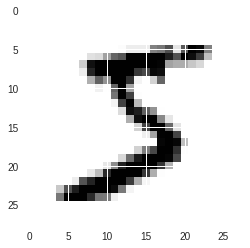

Number of training points 60000
Number of testing points 10000


In [3]:
training_data = datasets.MNIST(root='data/',
                            transform = transforms.ToTensor(),
                            train = True,
                            download = True) 

test_data = datasets.MNIST(root='data/',
                            transform = transforms.ToTensor(),
                            train = False,
                            download = True)

print(training_data[0][0][0])

plt.imshow(training_data[0][0][0],cmap = 'gray_r')
plt.show()

print('Number of training points', len(training_data))
print('Number of testing points', len(test_data))

In [0]:
batch_size = 128
#Generators
training_samples = torch.utils.data.DataLoader(dataset = training_data,
                                              batch_size = batch_size,
                                              shuffle = True) #Will shuffle after each time it trains

test_samples = torch.utils.data.DataLoader(dataset = test_data,
                                              batch_size = batch_size,
                                           )

In [0]:
class convnet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=5, stride=1) #Number of input channels (if colour then 3 because RGB), number of output channels, size of filter to apply, how much to shift filter by after doing dot product
    self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=5, stride=1)
    self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=5, stride=1)
    self.dense1 = torch.nn.Linear(32768,10) #Flattened at end so input to end is 32768 (to find out can just print x.shape after each relu) 
    
    self.bn1 = torch.nn.BatchNorm2d(32)
    self.bn2 = torch.nn.BatchNorm2d(64)
    self.bn3 = torch.nn.BatchNorm2d(128)
    
  def selu(self,x):
    scale = 1.0507009873554804934193349852946
    alpha = 1.6732632423543772848170429916717
    x[x>0] = scale*x
    x[x<=0] = scale*(alpha*x.exp() - alpha)
    return x
  
  def forward(self,x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x))).view(x.shape[0],-1) #Flattens it to basically get a 2d vector
    
    x = F.softmax(self.dense1(x), dim = 1) #Chooses highest value at the end and dim = 1 means that sum has to be 1
    return x
    

In [0]:
lr = 0.00075
epochs = 1 #Only 1 iteration because 60,000 data points should be enough to train

cnn = convnet()
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(cnn.parameters(),lr=lr)

In [0]:
def train(epochs):
  costs = []
  
  
  for e in range(epochs):
    for i, (x,y) in enumerate(training_samples): #enumerate gives current batch as i
      x, y = Variable(x), Variable(y)

      h = cnn.forward(x)
      cost = criterion(h, y)
      
      optimiser.zero_grad()
      cost.backward()
      optimiser.step()
      
      costs.append(cost.data[0])
      
      #print('Epoch: ', e, 'Batch: ', i, 'Cost', cost.data[0])
      
train(epochs)

In [31]:
def test():
  print('Started evaluation...')
  cnn.eval()
  
  correct = 0
  for x, y in test_samples:
    x = Variable(x) #Don't need to turn label into variable because we aren't trying to calculate cost, just what kind of number it is
    
    h = cnn.forward(x)
    pred = h.data.max(1)[1] #Will give probabilites and output so want [1] because aren't interested in probabilities but in fact the label associated with it
                            # the (1) tells you it is across each row, not each column (specifies the axis)
    correct += pred.eq(y).sum()
  
  return correct/len(test_data)

test()

Started evaluation...


0.8945